# Two-dimensional flows: vorticity and stream function method
v3.80, 14 April 2018, by Brian Fiedler

tweeked October 2023

$\newcommand{\V}[1]{\vec{\boldsymbol{#1}}}$
$\newcommand{\I}[1]{\widehat{\boldsymbol{\mathrm{#1}}}}$
$\newcommand{\pd}[2]{\frac{\partial#1}{\partial#2}}$
$\newcommand{\pdt}[1]{\frac{\partial#1}{\partial t}}$
$\newcommand{\ddt}[1]{\frac{\D#1}{\D t}}$
$\newcommand{\D}{\mathrm{d}}$
$\newcommand{\Ii}{\I{\imath}}$
$\newcommand{\Ij}{\I{\jmath}}$
$\newcommand{\Ik}{\I{k}}$
$\newcommand{\VU}{\V{U}}$
$\newcommand{\del}{\boldsymbol{\nabla}}$
$\newcommand{\dt}{\cdot}$
$\newcommand{\x}{\times}$
$\newcommand{\dv}{\del\cdot}$
$\newcommand{\curl}{\del\times}$
$\newcommand{\lapl}{\nabla^2}$

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display,clear_output
import time as Time
import math, os
import numpy as np
import scipy.fftpack
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
from IPython.core.display import HTML
import urllib.request

Matplotlib is building the font cache; this may take a moment.


In [6]:
#HTML(urllib.request.urlopen('http://metrprof.xyz/metr4323.css').read().decode())
HTML( open('metr4323.css').read() ) #or use this, if you have downloaded metr4233.css to your computer

### Example simulation

Here is my animation of an [unstable ring of vorticity](http://12characters.net/explore/vortringi.html),
(in this notebook, experiment `nexp=15`) computed in a `1025x1025` domain. On my computer with an I3 processor, the wall-clock time was about 90 minutes for the simulation.

### The model

The equations for two-dimensional, inviscid, incompressible flow of constant density:

$$
\pdt{u} + u \pd{u}{x} + v \pd{u}{y}= - \pd{P}{x}
$$

$$
\pdt{v} + u \pd{v}{x} + v \pd{v}{y}= - \pd{P}{y}
$$

$$
\delta \equiv \pd{u}{x} + \pd{v}{y}  = 0
$$

where $P$ denotes pressure divided by density: $P \equiv p/\rho$.  We will refer to $P$ as "pressure".

Are the equations dimensionless? We make no claims yet. Symbolically, the dimensionless equations and dimensional equations will look the same.

In contrast to the shallow-water equations, we don't see the height of the free surface $h(x,y,t)$ anymore, we just see pressure $P(x,y,t)$.  Also we see that the divergence of velocity is required to be zero.  In shallow-water theory, we saw that convergence raises $h$. Here $h$ is required to be a constant: a rigid surface exists at both the top and bottom boundary.

Peculiarly, we don't see any equation that prognosticates $P(x,y,t)$.  We can think of this rigid-lid model as having a free surface with very large $g$. Any small deflection of $h$ upward would cause a big increase in pressure that would cause divergence to bring down $h$ very quickly.  

As a consequence, gravity waves would have a very large speed.
We don't seek to explicitly model these gravity waves. That would require a very small time step in the numerical simulations.  We only want to model their effect on maintaining $\delta  = 0$, or very close to $0$.

Recall the definition of vertical vorticity:
$$
\zeta \equiv \pd{v}{x} - \pd{u}{y}
$$

You can show rather easily, from the top 3 equations, that  vorticity $\zeta$ is 
(theoretically) conserved when $\pd{u}{x} + \pd{v}{y}  = 0$:
$$
\ddt{\zeta} =0
$$

In our previous notebook, with a flexible upper lid, we did the more complicated derivation for conservation of potential vorticity:
$$
\ddt{}\left(\frac{ \zeta + f}{h} \right) =0
$$
Obviously, from that derivation, taking the case where $f$ and $h$ are constant, we recover $\ddt{} \zeta =0$

### Let's assume pressure has done it's job

If $\delta=0$, there must exist a *stream function* $\psi(x,y)$ consistent with  $\VU = u\Ii + v\Ij$:

$$
v =   \pd{\psi}{x}
$$
and
$$
u = - \pd{\psi}{y}
$$

With $(u,v)$ given this way, we are assured that: 
$$
\delta \equiv \pd{u}{x} + \pd{v}{y}  = 
-\pd{^2\psi}{ x \partial y} + \pd{^2 \psi}{y \partial x} = 0
$$

Streamlines are curves on which $\psi$ is constant.  You can easily show $\VU \dt \del \psi =0$, which means $\VU$ is tangent to streamlines.  

You can also show that $U^2 = |\del\psi|^2$, which means $\VU$ is inversely proportional to the distance between streamlines.

### Solving for $\psi$, u and v from $\zeta$

If we are given $\psi$, we can easily determine $u$,$v$ and then $\zeta$, using derivatives, or their equivalent for a gridded model.

Going the other way, meaning given $\zeta$ and then determining $\psi$, is a more difficult. But if we can do that, it would be very useful. 

We first recognize how $\zeta$ is related to $\psi$:
$$ 
\zeta \equiv \pd{v}{x} - \pd{u}{y} = \pd{^2\psi}{x^2} + \pd{^2\psi}{y^2} = \lapl \psi
$$

We can forecast $\zeta$ forward in time for one time-step with $\ddt{\zeta}=0$ or:

$$
\pdt{\zeta} = - u \pd{\zeta}{x} - v\pd{\zeta}{y} 
$$

We then solve $\lapl \psi = \zeta$ for $\psi$, and then solve for the updated $u$ and $v$.

### The Poisson equation

$\lapl$ is called the *Laplacian*.  Finding a function $\psi$ such that its Laplacian $\lapl\psi$ satisfies a specified function is called *solving the Poisson equation*:

$$
\lapl \psi = \zeta 
$$
Others might say that $\psi$ is the *inverse Laplacian* of $\zeta$.

### The Fourier method for solving the Poisson equation

The model domain will be $0\le x\le L$ and $0 \le y \le W$.
In our simulations, $\zeta=0$ on the boundaries initially, and so remains $0$.
So $\zeta(x,y)$ can be written as a Fourier series using sinusoids:

$$
\zeta(x,y) = \sum_{k,m} A_{k,m} \sin(kx)\sin(my)
$$
where
$$
k = K\frac{\pi}{L} \qquad m = M\frac{\pi}{W}
$$
and $K$ and $M$ are integers: $K=1,2,3 \ldots K_{max}$ and $M=1,2,3,\ldots M_{max}$.

For an `Nx` by  `Ny` grid, we will need $K_{max}=$ `Nx` -2 and $M_{max}=$ `Ny` -2. There will be as many 
Fourier modes as there are internal grid points.  For example, 1000 interior grid point of $\zeta$ are completely
specified by 1000 unique values of $A_{k,m}$.

Using "the most important numerical algorithm of our lifetime", 
the [Fast Fourier Transform](https://en.wikipedia.org/wiki/Fast_Fourier_transform) or FFT, 
we can quickly find the coefficients $A_{k,m}$ given the gridded $\zeta(x,y)$.

If we seek
$$
\psi(x,y) = \sum_{k,m} B_{k,m} \sin(kx)\sin(my)
$$
you might think that since 
$$
\lapl \psi(x,y) = \lapl \sum_{k,m} B_{k,m} \sin(kx)\sin(my) =  \sum_{k,m} B_{k,m} \lapl \sin(kx)\sin(my)=- \sum_{k,m} B_{k,m} (k^2+m^2) \sin(kx)\sin(my)
$$
$$
=\zeta(x,y) = \sum_{k,m} A_{k,m} \sin(kx)\sin(my)
$$
that we take the coefficients $A_{k,m}$ found from the FFT of $\zeta$, we then set
$$
B_{k,m} = \frac{-1}{k^2+m^2}A_{k,m} 
$$
The sum for $\psi$ (so-called invervse Fourier transform) would provide the answer for $\psi(x,y)$.


But it might be a bit more difficult than that for a grid-point model.  If we are trying to enforce:


$$
\lapl \psi(x,y) = \frac{1}{\Delta x^2} \left[ \psi(x-\Delta x, y) -2 \psi(x, y) + \psi(x+\Delta x, y) \right]
+\frac{1}{\Delta y^2} \left[ \psi(x, y-\Delta y) -2 \psi(x, y) + \psi(x,y+\Delta y) \right]
$$

$$
\lapl \psi = \lapl \sum_{k,m} B_{k,m} \sin(kx)\sin(my) =  \sum_{k,m} B_{k,m} \lapl \sin(kx)\sin(my)
$$
$$
=\sum_{k,m} 
\left\{ \frac{2}{\Delta x^2}\left[ \cos(k\Delta x) -1  \right] 
       +\frac{2}{\Delta y^2}\left[ \cos(m\Delta y) -1 \right] \right\}
B_{k,m} \sin(kx)\sin(my)
$$

So 
$$
B_{k,m} = \frac{1}{ \frac{2}{\Delta x^2}\left[ \cos(k\Delta x) -1  \right] 
       +\frac{2}{\Delta y^2}\left[ \cos(m\Delta y) -1 \right] } A_{k,m}
$$

Note that for a sufficiently small $k$ and $m$, the "discrete" form above simplifies to the "calculus" form
$$
B_{k,m} = \frac{-1}{k^2+m^2}A_{k,m} 
$$
We will explore in the tasks whether the discrete form or the calculus form provides any significant difference in a simulation. 

#### But where did that "discrete" form come from?

I will do simpler a demonstration. If $f(x) = \sin(kx)$, then the calculus second derivative is $f''(x) = -k^2\sin(kx)$.

The finite difference approximation is

$$
\pd{^2f}{x^2} = 
\frac{1}{\Delta x^2} \left[ f(x-\Delta x) -2 f(x) + f(x+\Delta x) \right]
$$
$$
= \frac{1}{\Delta x^2} \left[ \sin(kx-k\Delta x) -2 \sin(x) + \sin(kx+\Delta kx) \right]
$$
$$
= \frac{1}{\Delta x^2} \left[ \sin(kx)\cos(k\Delta x)- \cos(kx)\sin(k\Delta x) -2 \sin(x) 
+ \sin(kx)\cos(\Delta kx) + \cos(kx)\sin(\Delta kx) \right]
$$
$$
= \frac{1}{\Delta x^2} \left[ 2\cos(k\Delta x) -2 \right] \sin(x) 
$$

<hr/>

## Functions:

In [16]:
# Expands the margins of a matplotlib axis, 
# and so prevents arrows on boundaries from being clipped. 
def stop_clipping(ax,marg=.02): # default is 2% increase
    l,r,b,t = ax.axis()
    dx,dy = r-l, t-b
    ax.axis([l-marg*dx, r+marg*dx, b-marg*dy, t+marg*dy])

In [18]:
# dqdt requires a list of the time derivatives for q, stored 
# in order from present to the past
def ab_blend(dqdt,order):
    if order==1:
        return dqdt[0]
    elif order==2:
        return 1.5*dqdt[0]-.5*dqdt[1]
    elif order==3:
        return (23*dqdt[0]-16*dqdt[1]+5*dqdt[2])/12.
    else:
        print("order", order ," not supported ")

In [20]:
def advect(q,u,v,dx,dy): 
# third-order upwind advection
# q,u,v are co-located    
    dqdt = np.zeros(q.shape)
    
    dqmx = np.zeros(q.shape)
    dqpx = np.zeros(q.shape)
    dqmy = np.zeros(q.shape)
    dqpy = np.zeros(q.shape)
    
    dqmx[:,1]  = -q[:,0] + q[:,1] # 1st order, plus side at left wall
    dqmx[:,2:-1] = (q[:,:-3] - 6*q[:,1:-2] + 3*q[:,2:-1] + 2*q[:,3:])/6. # 3rd order, minus side
    dqpx[:,-2] = -q[:,-2] + q[:,-1] # 1st order, plus side at right wall
    dqpx[:,1:-2] = (-2*q[:,0:-3] - 3*q[:,1:-2] + 6*q[:,2:-1] -1*q[:,3:])/6. #3rd order, plus side

    dqmy[1,:]  = -q[0,:] + q[1,:] # 1st order, minus side at bottom wall
    dqmy[2:-1,:] =  (q[:-3,:] - 6*q[1:-2,:] + 3*q[2:-1,:] + 2*q[3:,:])/6. # 3rd order, minus side
    dqpy[-2,:] = -q[-2,:] + q[-1,:] # 1st order, plus side at top wall
    dqpy[1:-2,:] = ( - 2*q[0:-3,:]  - 3*q[1:-2,:] + 6*q[2:-1,:] - q[3:,:] )/6. # 3rd order, plus side


    dqdx = np.where(u>0.,dqmx,dqpx)/dx # upwind, emphasize side from where fluid is coming from
    dqdy = np.where(v>0.,dqmy,dqpy)/dy # ditto
    
    dqdt += -u*dqdx
    dqdt += -v*dqdy
    
    return dqdt

In [22]:
#############################################################
def divergence(u,v,dx,dy):
    # du/dx + dv/dy at p-grid
    div = .5*( u[:-1,1:] + u[1:,1:] - u[:-1,:-1] - u[1:,:-1])/dx + \
          .5*( v[1:,:-1] + v[1:,1:] - v[:-1,:-1] - v[:-1,1:])/dy
    return div
#############################################################
def vortp(u,v,dx,dy):
    # dv/dx - du/dy at p-grid
    vort = .5*( v[:-1,1:] + v[1:,1:] - v[:-1,:-1] - v[1:,:-1])/dx - \
           .5*( u[1:,:-1] + u[1:,1:] - u[:-1,:-1] - u[:-1,1:])/dy
    return vort 
#############################################################
def vortU(u,v,dx,dy):
    # dv/dx - du/dy at U-grid interior points
    vort = np.zeros(u.shape)
    vort[1:-1,1:-1] =  (v[1:-1,2:] - v[1:-1,:-2])/(2*dx) - \
                       (u[2:,1:-1] - u[:-2,1:-1])/(2*dy)
    return vort

In [24]:
def psi_to_uv(q,dx,dy):
# q is streamfunction (psi) on u-grid, assumed to be 0 on boundaries
# returns v = dq/dx and u= -dq/dy, on U-grid
    u = 0.*q
    v = 0.*q
    
    u[1:-1,1:-1] = -( q[2:,1:-1] - q[:-2,1:-1] )/(2*dy)
    u[0,1:-1] = -q[1,1:-1]/dy
    u[-1,1:-1] = q[-2,1:-1]/dy
  
    v[1:-1,1:-1] = +( q[1:-1,2:] - q[1:-1,:-2])/(2*dx)
    v[1:-1,0] =  q[1:-1,1]/dx
    v[1:-1,-1] = -q[1:-1,-2]/dx
    return u,v

In [26]:
def laplacian(p,dx,dy,il=None, ir=None, jb=None, jt=None):
# Returns Laplacian of p, d^2p/dx^2 + d^2/dy^2.
# If needed, specify how to grab the image of a point outside
# the domain.  Otherwise, the d^2p/dx^2 or d^2/dy^2 term is not included
# on the boundary.  
    rdx2 = 1./(dx*dx)
    rdy2 = 1./(dy*dy)
    lapl = np.zeros(p.shape)
    lapl[:,1:-1]  =  rdx2*( p[:,:-2] -2*p[:,1:-1] + p[:,2:] )
    lapl[1:-1,:] +=  rdy2*( p[:-2,:] -2*p[1:-1,:] + p[2:,:] ) 
    if il in [-2,-1,0,1]:    
        lapl[:,0]  +=  rdx2*( p[:,il] -2*p[:,0] + p[:,1] ) 
    if ir in [-2,-1,0,1]:    
        lapl[:,-1] +=  rdx2*( p[:,-2] -2*p[:,-1] + p[:,ir] )
    if jb in [-2,-1,0,1]:
        lapl[0,:]  +=  rdy2*( p[jb,: ] -2*p[0,:] + p[1,:] ) 
    if jt in [-2,-1,0,1]:
        lapl[-1,:] +=  rdy2*( p[-2,: ] -2*p[-1,:] + p[jt,:] ) 
    return lapl

In [28]:
def poisson_fft_prep(Nx,Ny,dx,dy,lapl='discrete'):
    # returns the coefficients to multiply the vorticity Fourier amplitudes
    L = dx*(Nx-1)
    W = dy*(Ny-1)
    
    Ka = np.arange(Nx-2) +1 # integer wavenumbers of the sine functions in the x-direction
    Ma = np.arange(Ny-2) +1 # integer wavenumbers of the sine functions in the y-direction
    ka = Ka*np.pi/L
    ma = Ma*np.pi/W
    
    lapl_op = np.zeros( (Ny-2,Nx-2) )
    if lapl == 'discrete':
        lapl_op[:] += (2*np.cos(ka*dx)-2)/dx**2 # add to every row
    else: # the calculus Laplacian
        lapl_op[:] += -ka**2 
    lapl_opT = lapl_op.T # reverse columns and rows
    if lapl == 'discrete':
        lapl_opT[:] += (2*np.cos(ma*dy)-2)/dy**2 # add to every row
    else: # the calculus Laplacian
        lapl_opT[:] += -ma**2
    lapl_op = lapl_opT.T # reverse columns and rows
    invlapl = 1./lapl_op #the coefficents for multiplying the vorticity Fourier amplitudes
    return invlapl 

def poisson_fft(vort, invlapl): 
    # solves for psi in del^2 psi = vort 
    cv = vort[1:-1,1:-1] # central vorticity
    
    #convert gridded vorticity to gridded Fourier coefficients A_k,m
    cvt = scipy.fftpack.dst( cv , axis=1 , type=1) 
    cvt = scipy.fftpack.dst( cvt , axis=0 , type=1)  
   
    cpsit = cvt*invlapl # Calculate B_k,m from A_k,m
    
    # convert array of Fourier coefficents for psi to gridded central psi
    cpsit = scipy.fftpack.idst(cpsit,axis=0,type=1) # inverse transform 
    cpsi = scipy.fftpack.idst(cpsit,axis=1,type=1) # inverse transform 

    sh = vort.shape
    psi = np.zeros(sh) # we need 0 on boundaries, next line fills the center
    psi[1:-1,1:-1] = cpsi/(4*(sh[0]-1)*(sh[1]-1)) # apply normalization convention of FFT
    return psi       

<hr/>

## Specify the grid:
Select a grid size that allows the Poisson solver to be fast.

2<sup>n</sup> +1 for `Nx` and `Ny` seems to be ideal.

In [31]:
# Make the grid. 257x257 allows for speed of the FFT
Nx = 257
Ny = 257
xmax = 1. # 0 <= x <= xmax
ymax = 1.
dx = xmax/(Nx-1.) # grid width
dy = ymax/(Ny-1.)
x1U = np.linspace(0,xmax,Nx)
y1U = np.linspace(0,ymax,Ny)
x1p = .5*(x1U[:-1]+x1U[1:])
y1p = .5*(y1U[:-1]+y1U[1:])
xU,yU = np.meshgrid(x1U,y1U)
xp,yp = np.meshgrid(x1p,y1p)

# An array of the inverse Laplacian, 
# to be applied to the Fourier components of the r.h.s. of the Poisson equation.
# This is calculated once, and used throughout the notebook.
invlapl = poisson_fft_prep(Nx,Ny,dx,dy)#,lapl='discrete') #lapl='calculus' or lapl='discrete'

### Test the Poisson solver

In [34]:
np.random.seed(2)
psi_test = np.zeros((Ny,Nx))
psi_test[1:-1,1:-1] = np.random.random((Ny-2,Nx-2))
vort_test = laplacian(psi_test,dx,dy)

In [36]:
#%%timeit
#psi_solved = poisson_fft(vort_test,invlapl)

Results from `%%timeit` study.

Note the great speed when using 2<sup>n</sup> +1 for `Nx` and `Ny` seems to be ideal.

| Nx &times; Ny | ms per loop |
|---|---|---|
| 127 x 127 | .876 |
| 128 x 128 | 13.5 |
| 129 x 129 | .747 |
| 130 x 130 | 2.76 |
| 255 x 255 | 31.7 |
| 256 x 256 | 4.51 |
| 257 x 257 | 2.74 |
| 258 x 258 | 109 |
| 512 x 512 | 52.2 |
| 513 x 513 | 15.4 |
| 514 x 514 | 22.5 |
| 515 x 515 | 285|
| 1023 x 1023 | 209 |
| 1024 x 1024 |134 |
| 1025 x 1025 | 75.8 |
| 1026 x 1026 | 172 |

In [39]:
# did the Poisson solver work??
psi_solved = poisson_fft(vort_test,invlapl)
diff = psi_test - psi_solved
diff2 = diff**2
print( "\nr.m.s error should be much less than 1:",diff2.mean() )


r.m.s error should be much less than 1: 4.232900482478221e-26


<hr/>

## Specify initial vorticity:

In [42]:
# choose an experiment number

nexp = 1

######
if nexp == 1: # shows vortex merger at about t=3
    vortorb =.11 # displacement of a vortex from center
    gwidth = .05 # width of vortex
    vortamp = 40 # amplitude of vorticity in vortex
    
elif nexp == 2: # shows vortex merger at about t=1.5
    vortorb =.11 
    gwidth =.05
    vortamp = 80
    
elif nexp == 3: #  shows a vortex merger at t=10
    vortorb = .12
    gwidth =.05
    vortamp = 80

elif nexp == 4: # shows no  vortex merger before t=20
    vortorb = .22 # twice the orbital radous
    gwidth = .10 # twice the gaussian width of 2
    vortamp = 20 # so same circulation as 2
    
elif nexp == 10: # thick unstable vortex sheet
    vortamp =4.
    gwidth =.1
    xcen = .5 
    ycen = .5
elif nexp == 11: # thick unstable vortex sheet, off-center intialization
    vortamp = 4.
    gwidth = .1
    xcen = .53 # use .53 to break symmetry
    ycen = .51 # use .51 to break symmetry
    
    
elif nexp == 12: # thin unstable vortex sheet
    vortamp = 8.
    gwidth = .05
    xcen = .5
    ycen = .5    
elif nexp==13: # thin unstable vortex sheet, off-center intialization
    vortamp = 8.
    gwidth =.05
    xcen = .53 # use .53 to break symmetry
    ycen = .51 # use .51 to break symmetry
    
elif nexp == 14: # very thin unstable vortex sheet
    vortamp = 16.
    gwidth = .025
    xcen = .5 
    ycen = .5    
elif nexp == 15: # very thin unstable vortex sheet
    vortamp = 16.
    gwidth = .025
    xcen = .53 # use .53 to break symmetry
    ycen = .51# use .51 to break symmetry

else:
    print(nexp," not valid")
    
if nexp<10: # vortex pairs
    xcA = .5*xmax-vortorb # x center of vortex A
    ycA = .5*ymax # y center of vortex A
    xcB = .5*xmax+vortorb # x center of vortex B
    ycB = .5*ymax # y center of vortex B       
    vorti  =  vortamp*np.exp( -((xU-xcA)/gwidth)**2 -((yU-ycA)/gwidth)**2)  \
            + vortamp*np.exp( -((xU-xcB)/gwidth)**2 -((yU-ycB)/gwidth)**2)        
else: # vortex ring
    r2 = (xU-xcen)**2 + (yU-ycen)**2 
    r = np.sqrt(r2)
    vorti = vortamp*np.exp(-((r-.35)/gwidth)**2)

# Use b as a passive tracer for now, simply advect it. Initialize as increasing with y
# Will be more interesting when b is becomes active, as buoyancy.   
bi = yU.copy() # initial b

<hr/>

## Solve for initial u and v:

In [45]:
psii = poisson_fft(vorti,invlapl) # solve for initial psi
lapl_psii = laplacian(psii,dx,dy) # should recover vorti
ui,vi = psi_to_uv(psii,dx,dy) # solve for initial u and initial v from initial psi

In [47]:
# check if poisson solver is working
print("vort, maximum value:", vorti.max() )
print("root mean square vort:", np.sqrt( (vorti*vorti).mean() ) )
print("calculated psi, min value:", psii.min() )
print("laplacian of psi, max value:", lapl_psii.max() )
sqdiff = ( lapl_psii - vorti )**2
rms = np.sqrt(sqdiff.mean())
print("root mean square (lapl_psi - vort):",rms)
print("psi -> u,v -> vortU, max value:", vortU(ui,vi,dx,dy).max())
print("max u:",ui.max())
print("max v:",vi.max())

vort, maximum value: 3.999375066276704e+01
root mean square vort: 3.5312246701911785
calculated psi, min value: -0.1794978136757414
laplacian of psi, max value: 39.99375066276298
root mean square (lapl_psi - vort): 2.7081246527529874e-12
psi -> u,v -> vortU, max value: 39.81038570202463
max u: 0.691806844433767
max v: 0.824569137461328


In [49]:
vd=4 # vector skip in arrow plots (vd=1 plots all arrows)

vortlevs = np.linspace(-0.1*vortamp,1.1*vortamp,7)
print('contour levels for vorticity:',vortlevs)

psilevs=np.linspace(3*psii.min(),psii.max(),30) # factor of 3 accomodates stengthening vortex
print('contour levels for psi:',psilevs)

blevs = np.linspace(-.05,1.05,12)
print('contour levels for b:',blevs)

contour levels for vorticity: [-4.  4. 12. 20. 28. 36. 44.]
contour levels for psi: [-0.53849344 -0.5199247  -0.50135596 -0.48278722 -0.46421848 -0.44564974
 -0.427081   -0.40851227 -0.38994353 -0.37137479 -0.35280605 -0.33423731
 -0.31566857 -0.29709983 -0.27853109 -0.25996235 -0.24139361 -0.22282487
 -0.20425613 -0.18568739 -0.16711865 -0.14854991 -0.12998118 -0.11141244
 -0.0928437  -0.07427496 -0.05570622 -0.03713748 -0.01856874  0.        ]
contour levels for b: [-0.05  0.05  0.15  0.25  0.35  0.45  0.55  0.65  0.75  0.85  0.95  1.05]


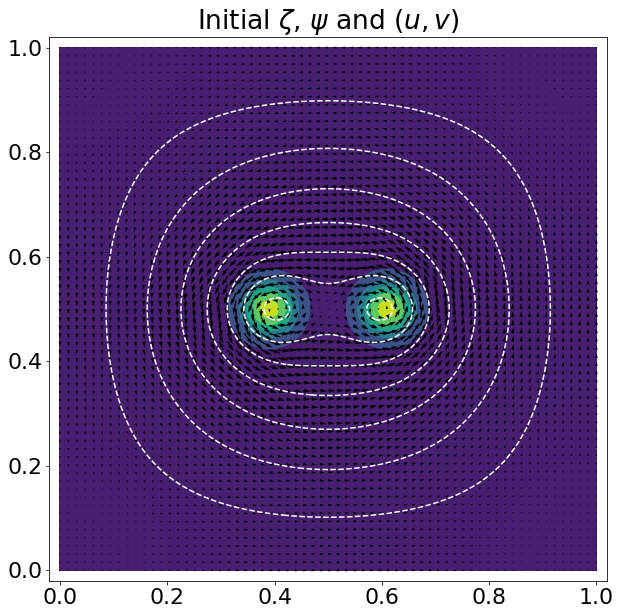

In [51]:
quick,simple = plt.subplots(figsize=(10,10))
if abs(vorti).max()>1.e-12: CV = simple.contourf(xU,yU,vorti,vortlevs)
#plt.clabel(CV, fontsize=9, inline=1);
if abs(psii).max()>1.e-12: 
    simple.contour(xU,yU,psii,colors=('w',) )
    simple.quiver(xU[::vd,::vd],yU[::vd,::vd],ui[::vd,::vd],vi[::vd,::vd])
simple.set_title("Initial $\zeta$, $\psi$ and $(u,v)$")
stop_clipping(simple)

<hr/>

## Set up the animation plot:

In [54]:
myfig = plt.figure(figsize=(10,10),facecolor='lightgrey')
ax2 = myfig.add_axes([0.1, 0.1, 0.8, .8*ymax/xmax],frameon=False) # contour axes
ax3 = myfig.add_axes([0.0, 0.1, 0.08, .8]) # for colorbar
ax3.axis('off')
ax2.axis('off')
plt.setp( ax2.get_xticklabels(), visible=False);
plt.close()
cbar_exists = False

In [56]:
def doplot():
    global cbar_exists
    matplotlib.rcParams.update({'font.size': 22})
    ax2.clear()
    CF = ax2.contourf(xU,yU,vort,vortlevs,zorder=2)
    if abs(psi).max()>1.e-12: ax2.contour(xU,yU,psi,psilevs,colors=('w',),zorder=4)

# To see b, uncomment one of the following:
#    ax2.contour(xU,yU,b,blevs,colors=('g',),zorder=5)
#    ax2.contourf(xU,yU,b,blevs,zorder=5)
 
    ax2.axis('off')
    Q = ax2.quiver(xU[::vd,::vd],yU[::vd,::vd],u[::vd,::vd],v[::vd,::vd],
           scale=0.5*speedmax*Nx/vd,units='width',zorder=3)
    speedf = "%7.3f"  % speedmax
    ax2.quiverkey(Q,-.1,.95,speedmax,speedf,zorder=4)

    ax2.text(.5,-.05,expt,fontsize=18)
    ax2.text(.05,-.05,'t={0:5.3f}'.format(t),fontsize=22)

    stop_clipping(ax2)
    if not cbar_exists:
        mycbar = myfig.colorbar(CF,ax=ax3,fraction=0.4)
        mycbar.ax.yaxis.set_ticks_position('left')
        sooner = mycbar.ax.yaxis.get_ticklabels()
        for boomer in sooner:
            boomer.set_fontsize(12)
        cbar_exists = True
        
    clear_output(wait=True)
    display(myfig)
    if outdir: 
        timestamp = 100*round(t,2)
        pngname = outdir+'/%06d.png' % round(timestamp) 
        myfig.savefig(pngname, dpi=72, facecolor='w', edgecolor='w', orientation='portrait')

<hr/>

## Set parameters for the numerical solution:

In [59]:
if nexp<10: # two vortices
    speedmax = .5*vortamp*gwidth # estimated maximum speed that will occur
else: # ring
    speedmax = 2.*vortamp*gwidth # estimated maximum speed that will occur
    
cfl = .3 # if parcel moves at speedmax, fraction of dx it is allowed to traverse 
dt = cfl*dx/speedmax # restrict dt by cfl choice

if nexp<10:
    diffusion_coef = dx*dx/8 # = dx*dx/8 would cause "2-delta-x" waves to decay with time scale of 1
else:
    diffusion_coef = 0.
    
aborder = 3 # Adams-Bashforth order: 1, 2 or 3

expt = '%d,%d,%3.2f,%8.2e,%8.2e' % (Nx, nexp, cfl, dt, diffusion_coef)
print(expt)

outdir='saveit' # set = None, if you don't want save PNG images
if outdir and not os.path.exists(outdir): os.mkdir(outdir)

257,1,0.30,1.17e-03,1.91e-06


<hr/>

## Start from t=0:

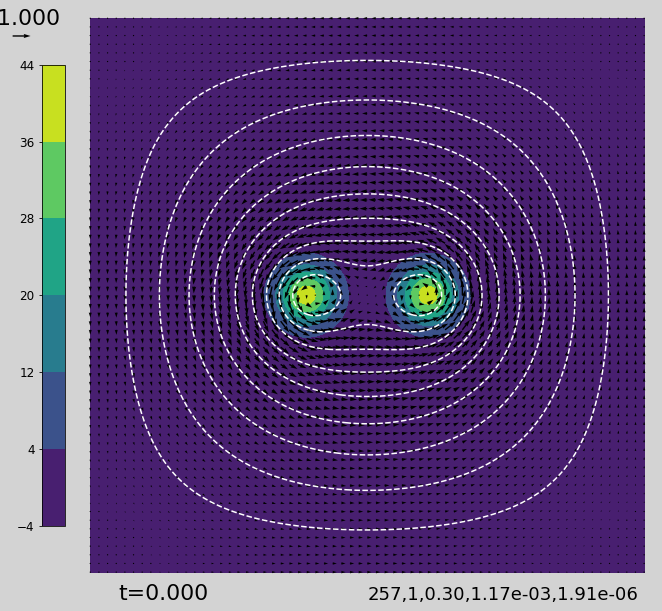

In [64]:
# copy initial fields to model fields
dvortdta = [None]*3
dbdta = [None]*3
vort = vorti.copy()
b = bi.copy()
u = ui.copy()
v = vi.copy()
psi = psii.copy()

vstore1 = []
vstore2 = []
vstore3 = []
vstore4 = []
tstore = []
dist_from_center = np.sqrt( (xp-.5*xmax)**2 + (yp-.5*ymax)**2 )
alignment = abs(xp-.5*xmax) - abs(yp-.5*ymax)

nstep = 0
t = 0.

doplot()

<hr/>

## Run the model forward in time:

[About using `%%prun`](https://stackoverflow.com/a/34545094). 

[how to interpret the output of prun](http://stackoverflow.com/questions/7069733/how-do-i-read-the-output-of-the-ipython-prun-profiler-command).

In [67]:
tstop = 4
dplot = .1 # time between plots
tplot = t # time for next plot 

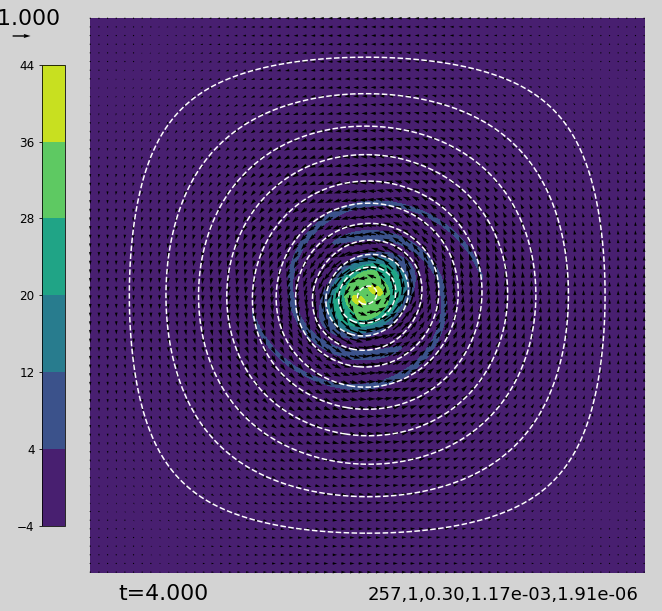

In [69]:
#%%prun 
# benchmark this cell by removing the above comment symbol to use %%prun

while t < tstop - dt/2. :
 
    nstep += 1

    abnow = min(nstep,aborder)
    
    psi = poisson_fft(vort,invlapl)

    u,v = psi_to_uv(psi,dx,dy)
    
    dvortdt = advect(vort,u,v,dx,dy) 
    if diffusion_coef>0:
        dvortdt += diffusion_coef*laplacian(vort,dx,dy)
    
    dvortdta = [dvortdt.copy()] + dvortdta[:-1]

    vort += dt*ab_blend(dvortdta, abnow)
    
    dbdt = advect(b,u,v,dx,dy)
    dbdta = [dbdt.copy()] + dbdta[:-1]
    b += dt*ab_blend(dbdta, abnow)
       
    t = t + dt
    
    vstore1.append( vort.max() )
    vortpgrid = vortp(u,v,dx,dy)
    circulation = dx*dy*vortpgrid.sum() # integral of zeta over domain
    vstore2.append( circulation )
    vstore3.append( dx*dy*(dist_from_center*vortpgrid).sum()/circulation )
    vstore4.append( dx*dy*(alignment*vortpgrid).sum()/circulation)
    
    tstore.append(t)
    
    assert u.max()<2.e10, 'kaboom!'
    
    if t > tplot - dt/2. : 
        doplot()
        tplot = min(tstop,tplot + dplot)


## Look at some simulation histories:

39.99351165027437 38.185828662184356


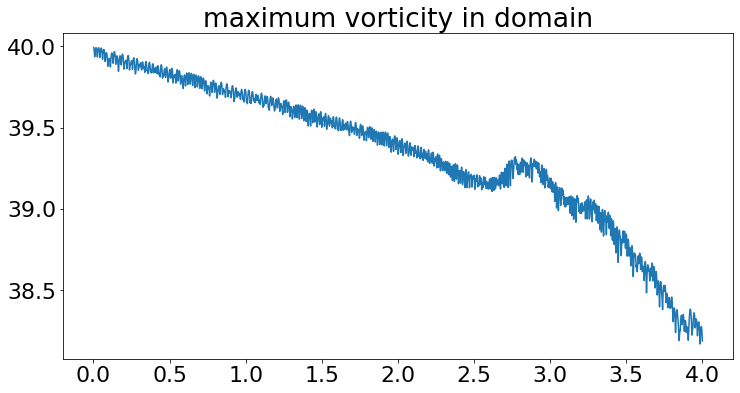

In [72]:
quick,simple = plt.subplots(figsize=(12,6))
simple.plot(tstore,vstore1)
simple.set_title('maximum vorticity in domain')
print(vstore1[0],vstore1[-1])

0.6283185307174792 0.6248756413201535


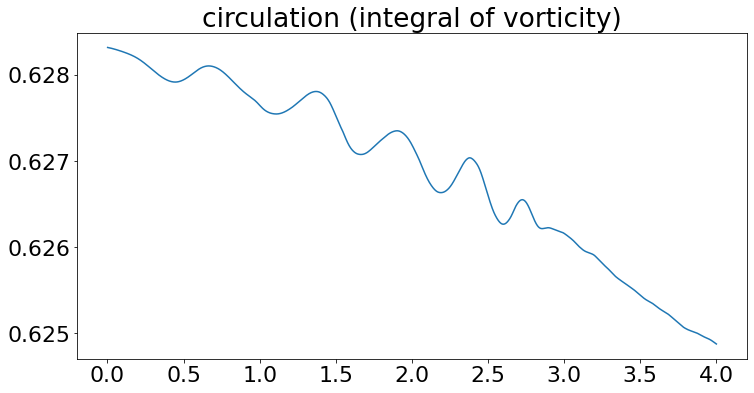

In [74]:
quick,simple = plt.subplots(figsize=(12,6))
simple.plot(tstore,vstore2)
simple.set_title('circulation (integral of vorticity)')
print(vstore2[0],vstore2[-1])

0.11588408024087257 0.09450372375051797


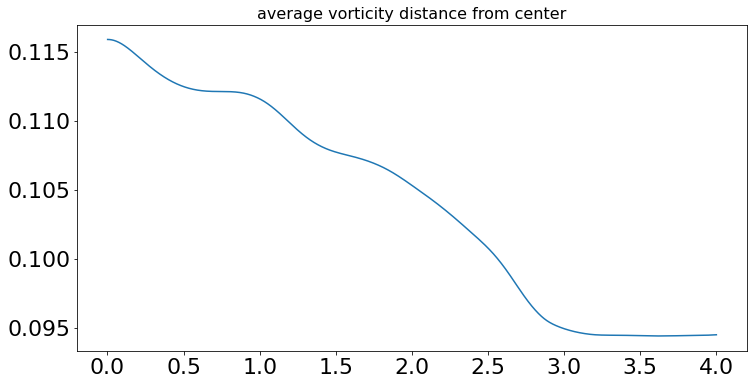

In [76]:
# relevant to vortex merger
quick,simple = plt.subplots(figsize=(12,6))
simple.plot(tstore,vstore3)
simple.set_title('average vorticity distance from center',size=16)
print(vstore3[0],vstore3[-1])

0.08175174181824159 -0.0005642450715256123


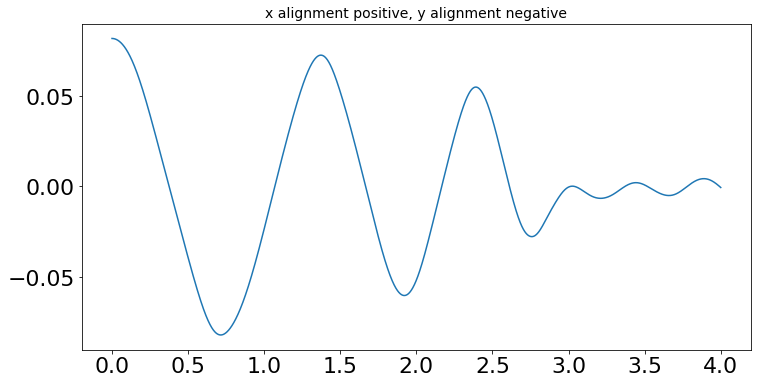

In [78]:
# relevant to vortex merger
quick,simple = plt.subplots(figsize=(12,6))
simple.plot(tstore,vstore4);
simple.set_title('x alignment positive, y alignment negative',size=14)
print(vstore4[0],vstore4[-1])


In [80]:
circulation

0.6248756413201535

In [82]:
dx*dy*vortp(u,v,dx,dy).sum()

0.6248756413201535

In [84]:
- dx*u[-1,:].sum() + dy*v[:,-1].sum() + dx*u[0,:].sum() -dy*v[:,0].sum()

0.6248756413201535

The theory for $T_o$, or `T_orbit`, is not difficult. It is [in a book](https://books.google.com/books?id=sTpOGjZohEwC&lpg=PA127&ots=vMxDU4BVFv&dq=period%20co-rotating%20vortices&pg=PA127#v=onepage&q=period%20co-rotating%20vortices&f=false), if you need it.  The theory appears to give a prediction within 10% of what we observe in the simulations.

In [87]:
circ1 = circulation/2 # circulation in single vortex

In [89]:
T_orbit = 8*np.pi**2*vortorb**2/circ1
T_orbit

3.0578170850348907

## Student tasks:

### 1. Two vortex merger

Hey students I am trying to figure this out. So have a lot of other nerds.  Google "vortex merger".
Check this out: [Fujiwhara effect](https://en.wikipedia.org/wiki/Fujiwhara_effect)

In `vstore2` I have:
$$\Gamma = \int \int \zeta~dx~dy $$

With 
$$ r \equiv \sqrt{(x-x_c)^2+(y-y_c)^2} $$

$$ a \equiv |x|-|y| $$

I have this in `vstore3`
$$ \frac{1}{\Gamma} \int \int r \zeta~dx~dy  $$

and this  in `vstore4`
$$ \frac{1}{\Gamma} \int \int a \zeta~dx~dy  $$

Looking at a time trace of the diagnostics, I can see a good record of what I see in the animations: an obvious time of vortex merger.

METR 4323 students suffered for a couple of semesters to find a rule for the ratio of time of merger $T_m$ to the time of orbit $T_o$.  It was hoped that we could discover how $T_m/T_o$ increases with `vortorb/gwidth`. Comparing
`nexp=3` with `nexp=2` certainly shows $T_m/T_o$ can *strongly* increase with `vortorb/gwidth`.

The research project became difficult because it was presumed that the walls of the domain were far enough away to not have a significant effect.  That turns out not to be the case: `nexp=4` is geometrically similar to `nexp=1` and `nexp=2` but never merged. We concluded the nearness of wall prevents vortex merger.

So we could attempt to keep the walls far away.  But that requires a finer grid to resolve the vortices, which are
kept near the center.  The simulations take too long to run.  Too tedious.

So in 2017, we get a life...


### 2. Be creative

 * What happens if we knock off about 30% of the amplitude of one of the co-rotating vortices?   
 * What happens if we initialize with *counter-rotating* vortices?
 * What if we initialize with three vortices, maybe in a line, maybe as an equilateral triangle, maybe not all the same strength? Maybe one counter-rotating?
 * What about nested vortex rings ... of opposite sign?
 * What if spell your name with the initial vorticity?
 * What about.... you think of something.
 


# Appendix

## Fast Fourier Transform demonstration

Below we demonstrate the *discrete sine transform* function `dst`
and the *inverse discrete sine transform* function `idst`.

The official [scipy FFT docs](https://docs.scipy.org/doc/scipy-0.18.1/reference/fftpack.html) are probably not
needed. Hopefully the example will lead to adequate understanding of what we are trying to accomplish.

In [94]:
ip = 5 # number of internal grid points
x = np.linspace(0,1, ip+2)
print(x)

[0.         0.16666667 0.33333333 0.5        0.66666667 0.83333333
 1.        ]


In [96]:
# Make a discrete function from sine waves.
# Try setting one of the amplitudes to 0.0
# Also note the 5, which is the maximum allowed with ip=5
fun_sines = 1.0*np.sin(np.pi*x) + 1.0*np.sin(5*np.pi*x)
print(fun_sines)

[ 0.00000000e+00  1.00000000e+00 -4.44089210e-16  2.00000000e+00
  8.88178420e-16  1.00000000e+00  7.34788079e-16]


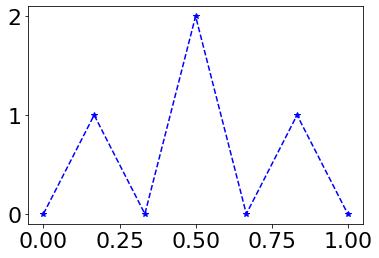

In [98]:
plt.plot(x,fun_sines,'b*--');

In [100]:
# End points of fun_sines are 0, and the type=1 sine FFT does not need the end points
ifuns = fun_sines[1:-1] # slice of internal points
amps_of_sines = scipy.fftpack.dst(ifuns,type=1)/(len(ifuns)+1) #  note normalization in the denominator
print(amps_of_sines) # did you reconver what the amplitudes you started with?

[ 1.00000000e+00 -1.45372722e-16 -1.48029737e-16  6.23812352e-16
  1.00000000e+00]


In [102]:
# Demonstrate the inverse transform. idst is much faster than what we
# did above with: fun_sines = 1.0*np.sin(np.pi*x) + 1.0*np.sin(5*np.pi*x)
fun_sines_from_idst = scipy.fftpack.idst(amps_of_sines,type=1)/2 # note normalization with 2
print(fun_sines_from_idst)

[ 1.00000000e+00 -3.83133735e-16  2.00000000e+00  9.49133894e-16
  1.00000000e+00]


## an iterative Poisson solver

Traditionally, introductory numerical methods teach approximate, iterative solutions to $\lapl \psi = \zeta$. At every time $t$ you can *diffuse* $\psi$ with a time-like variable $\tau$.

$$
\pd{\psi}{\tau} = \nabla^2\psi - \zeta
$$

Or

$$
\psi(x,y,\tau+\Delta\tau) =  \psi(x,y,\tau) + \Delta\tau \left( \lapl\psi - \zeta \right)
$$

If we had the computational luxury of diffusing $\psi$ for many iterations at each forward time step, we might hope that $\psi$ has "relaxed" to a steady state, which means
$$ \nabla^2\psi - \zeta \approx 0
$$

We could diffuse with a special value of $\Delta \tau$  that pushes the iteration to the limit of stability. The "diffusion" that we speak of will look
like we are going thrugh a loop many times that replaces the value of $\psi$ at a point by the average of its four neighbors, plus another term.  

I will be modern, and not ask you to code it or test it. It needs *many* iterations to converge. It's slow.  It just isn't  much fun.  Thank goodness for FFTs!

In [106]:
def iterative_poisson( qfirstguess, del2q, dx, dy, niterations):
# all fields are on the u grid
# finds q that solves the poisson equation for q
# given the value del2q to shoot for, find q that satisfies:
# d^2q/dx^2 + d^2q/dy^2 = del2q
# commonly q is stream function, and del2q is vorticity
#
# This is what we desire, (but this is not valid Python):      
#         0 = rdx2*( q[1:-1,:-2] -2*q[1:-1,1:-1] + q[1:-1,2:] ) 
#          +  rdy2*( q[:-2,1:-1] -2*q[1:-1,1:-1] + q[2:,1:-1] ) 
#           - del2q[1:-1,1:-1] )
# We hope repeatedly doing this converges q closer to the desired result:      
# 2*(rdx2+rdy2)*q[1:-1,1:-1]  = rdx2*( q[1:-1,:-2] + q[1:-1,2:] ) 
#                             + rdy2*( q[:-2,1:-1] + q[2:,1:-1] ) 
#                             - del2q[1:-1,1:-1] )
# To make the above a valid python statement, we need to divide both sides 
# by 2*(rdx2+rdy2)

    rdx2 = 1./(dx*dx)
    rdy2 = 1./(dy*dy)
    q = qfirstguess.copy()
    for n in range(niterations):
        q[1:-1,1:-1] = 1./(2*rdx2 + 2*rdy2) * \
         (  rdx2*( q[1:-1,:-2] + q[1:-1,2:]) \
          + rdy2*( q[:-2,1:-1] + q[2:,1:-1]) \
          - del2q[1:-1,1:-1] )
    return q 

## Animating your PNGs for the web

You can make an animation of your PNG, that can be viewed independent of your notebook.  Use [this code](https://code.activestate.com/recipes/580675-makes-html-with-javascript-to-animate-a-sequence-o). Download the python file and name it `janim.py`. Below I show how to `import janim` as a module and use the function `makeanim`.  It is quite simple.

In [109]:
from janim import makeanim
import glob

In [111]:
pngs = glob.glob(outdir+'/*.png') # the * matches anything
pngs.sort()
#if using Windows, get rid of file paths that use \
pngsfixed = [x.replace('\\','/') for x in pngs] # fixes Windows
print(pngs)
print(pngsfixed)

['saveit/000000.png', 'saveit/000010.png', 'saveit/000020.png', 'saveit/000030.png', 'saveit/000040.png', 'saveit/000050.png', 'saveit/000060.png', 'saveit/000070.png', 'saveit/000080.png', 'saveit/000090.png', 'saveit/000100.png', 'saveit/000110.png', 'saveit/000120.png', 'saveit/000130.png', 'saveit/000140.png', 'saveit/000150.png', 'saveit/000160.png', 'saveit/000170.png', 'saveit/000180.png', 'saveit/000190.png', 'saveit/000200.png', 'saveit/000210.png', 'saveit/000220.png', 'saveit/000230.png', 'saveit/000240.png', 'saveit/000250.png', 'saveit/000260.png', 'saveit/000270.png', 'saveit/000280.png', 'saveit/000290.png', 'saveit/000300.png', 'saveit/000310.png', 'saveit/000320.png', 'saveit/000330.png', 'saveit/000340.png', 'saveit/000350.png', 'saveit/000360.png', 'saveit/000370.png', 'saveit/000380.png', 'saveit/000390.png', 'saveit/000400.png']
['saveit/000000.png', 'saveit/000010.png', 'saveit/000020.png', 'saveit/000030.png', 'saveit/000040.png', 'saveit/000050.png', 'saveit/000

In [113]:
makeanim(pngsfixed,outfile="myanimator.html",sortOrder=True,
         ctlOnSide=True,titlestring="Animation of Vortex Dynamics")

Now open the file you made locally in your browser: [myanimator.html](myanimator.html).